# Part B: Analayze field of multiple 2 galaxy blends

A catsim-like catalog with multiple two-galaxy blends with different orientations and extent of overlap was created previously. This was then provided as input to the [DESC Weak Lensing Deblending Package](http://weaklensingdeblending.readthedocs.io/en/latest/index.html) (hereafter WLD) and the ouput image analyzed with LSST DM science pipeline (v14.0).  We look at the input and output below.

In [49]:
import numpy as np
from astropy.table import Table, Column
from scipy import spatial
%matplotlib inline
import matplotlib.pyplot as plt
import fitsio

plt.rc('image', origin='lower',
       interpolation='none')
plt.rc('figure.subplot', wspace=0.3)
plt.rc('figure.subplot', hspace=0.3)


### Input Catalog Description:
The catsim-like catalog was created to represent a 576 $\times$ 2880 pixel field, as a combination of 720 postage stamps (each 48 $\times$ 48 pixels). Each postage stamp consits of a two *identical* galaxies with different orientations and with different distance between them. The pair centers have the same y coordinate, thereby difference in centers is just the difference in x cordinate of the centers.
For each galaxy pair, postage stamps are created for:
1. Distance between pair centers are 2, 4 and 6 times the semimajor axis, or overlap extent of 1,2,3 respectively
1. Major axis of the 2 galaxies are oriented at angles of 0, 45 and 90deg, or angle of approach of 0, 45 and 90deg respectively.

For each blend pair from 1) and 2) both galaxies are also rotated by 0,45,90 and 135 degrees. 
Every distinct galaxy pair will have 3 rows of postage stamp; a specific angle of approach, on each row 
Each row of postage stamps has the 4 different rotations of the galaxies for each of the 3 extent of overlaps.
Each distinct galaxy pair has 3 rows and 12 columns of postage stamps.

20 galaxies were selected at random from the One square deg catsim catalog with i band magnitude $<$24 forming the distinct galaxy pairs.

add image of one distinct galaxy pair stamps

In [50]:
data_dir = "/global/projecta/projectdirs/lsst/groups/WL/projects/wl-btf/two_gal_blend_data/" 
data_dir = "data/" 

In [51]:
# Read the output from WLD
wl_out = Table.read(data_dir + 'mock_gal_pairs_wldeb.fits',
                    format= 'fits', hdu=1)

In [52]:
# Read in the output from DM
dm_all = Table.read(data_dir + 'mock_gal_pairs_dm.fits',
                    format= 'fits', hdu=1)

### Quantify "blendedness"
WLD has a parameter to denote how "blended" a given galaxy is:
- `Purity`: Purity of this source in the range 0-1 (equals 1 when grp_size is 1)
$$purity = \frac{\sum_p s_{ip}\cdot s_{ip}}{\sum_p (s_{ip}\cdot \sum_j s_{jp})} $$
where the sums over $p$ are over all pixels within the overlapping group and the sum over $j$ is over all sources with any overlap with source $i$, including $i$ itself. Purity is then a ratio of weighted flux estimates over pixels where we treat the object as being isolated in the numerator and include overlaps in the denominator, and use the true profile of source $i$ for the weights in both cases. 
By construction, $0 < purity \le 1$ with $ purity = 1$ for perfectly isolated sources.

There is an equivalent parameter computed by DM: 
- Blendedness parameter: name= `base_Blendedness_old`, "blendedness from dot products:(child.dot(parent)/child.dot(child) - 1)"  
$$Blendedness = \frac{\sum_p (s_{ip}\cdot \sum_j s_{jp})} {\sum_p s_{ip}\cdot s_{ip}} - 1 $$
sum over $j$ is over all sources with any overlap with source $i$,*NOT* including $i$ itself
$$purity = 1/(1 + Blendedness)$$

Let's compute the equivalent purity for the DM output

In [53]:
purity = 1/(1 + dm_all['base_Blendedness_old'])
col = Column(purity, name="purity")
dm_all.add_column(col)

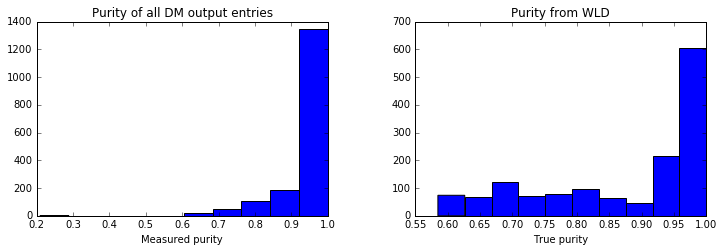

In [54]:
plt.figure(figsize=[12,8])
plt.subplot(2,2,1)
plt.hist(dm_all['purity'])
plt.title("Purity of all DM output entries")
plt.xlabel("Measured purity")
plt.subplot(2,2,2)
plt.hist(wl_out['purity'])
plt.title("Purity from WLD")
plt.xlabel("True purity")

### Blending heirarchy
A “family” to refer to group of blended objects, and “child” to refer to a particular deblended object within a family. A “parent” is also created for each family, representing the alternate hypothesis that the blend is actually a single object. Blends may be hierarchical; a child at one level may be a parent at the level below. For each parent, `deblend_nChild` gives the number of children an object has.

The output DM catalog saves measurement for both parents and children. Catalog entries with `deblend_nChild`=0 are only children, catalog entries with `parent`=0 are only parents. WLD defines a group as set of galaxies that have at least one pixel overlap, and computes the number of members in group as `grp_size` . We compute an equivalent value for the DM output by counting the number of children in the parent of a given entry, and the number of children in the parent of parent and so on till `parent`=0. 

In [55]:
def get_grp_size(cat, id_in):
    """Returns number of DM children connected to input source.
    Computes sum of nuber of children of a source's parent and its parent
    and henceforth till an isolated parent is reached"""
    num = 0
    row = cat[cat['id'] == id_in]
    if row['parent'] == 0:
        return 1
    while (row['parent'] != 0):
        new_id = int(row['parent'])
        row = cat[cat['id'] == new_id]
        num += int(row['deblend_nChild'])
    return num

grp_size = np.zeros(len(dm_all))
for i in range(len(dm_all)):
    grp_size[i] = get_grp_size(dm_all, dm_all["id"][i])
col = Column(grp_size, name="grp_size")
dm_all.add_column(col)

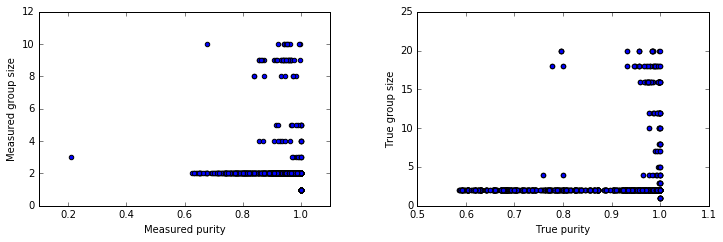

In [56]:
plt.figure(figsize=[12,8])
plt.subplot(2,2,1)
plt.scatter(dm_all['purity'], dm_all['grp_size'])
plt.xlabel("Measured purity")
plt.ylabel("Measured group size")
plt.subplot(2,2,2)
plt.scatter(wl_out['purity'], wl_out['grp_size'])
plt.xlabel("True purity")
plt.ylabel("True group size")

We can separate out just the children by selecting `deblend_nChild`=0

In [57]:
dm_out = dm_all[dm_all["deblend_nChild"]==0]
dm_image = fitsio.read(data_dir + 'mock_gal_pairs_dm_image.fits',ext=0)

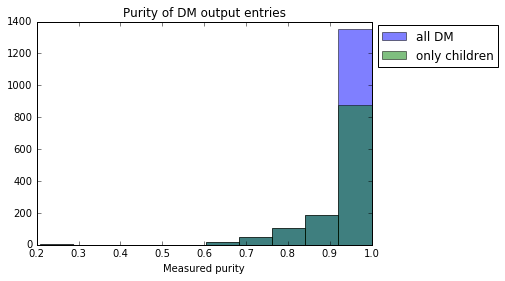

In [58]:
plt.hist(dm_all['purity'], label='all DM', alpha=0.5)
plt.hist(dm_out['purity'], label='only children', alpha=0.5)
plt.title("Purity of DM output entries")
plt.xlabel("Measured purity")
plt.legend(bbox_to_anchor=(1.,1.01), loc=2)

### Match true and measured
To compare input and output parameters, we match the centers of the DM output to the input catalog.
For a given DM entry we do this by finding the nearest true center within a tolerance value (here 5 pixels).

This is not the best method. Can you think of a reason why?

In [59]:
def get_match(tru_cat, det_cat,
              im_shape, tolerance=5):
    """Returns index of true catalog that are the closest 
    match to the detected catalog centers within the tolerance
    limit.
    """
    z1 = np.zeros((len(tru_cat),2)) 
    z1[:,0] = np.array(tru_cat['dx']/0.2 + (im_shape[1]-1)/2.)
    z1[:,1] = np.array(tru_cat['dy']/0.2 + (im_shape[0]-1)/2.)
    z1_tree = spatial.KDTree(z1)
    z2 = np.zeros((len(det_cat),2)) 
    z2[:,0] = det_cat['base_GaussianCentroid_x']
    z2[:,1] = det_cat['base_GaussianCentroid_y']
    match = z1_tree.query(z2, distance_upper_bound=tolerance)
    return match

match = get_match(wl_out, dm_out,dm_image.shape)

Some of the DM outputs might be spurious detections, so we remove the DM children with nan flux

In [60]:
select_dm, = np.where((~np.isinf(match[0])) &(~np.isnan(dm_out["base_SdssShape_flux"])))
select_wldeb = match[1][select_dm]
match_dm = match[1][~np.isinf(match[0])]
#print (f"Number of detected children is {len(dm_out)} out of {len(wl_out)} simulated galaxies")
#print (f"Number of true matched detections is {len(select_dm)}")

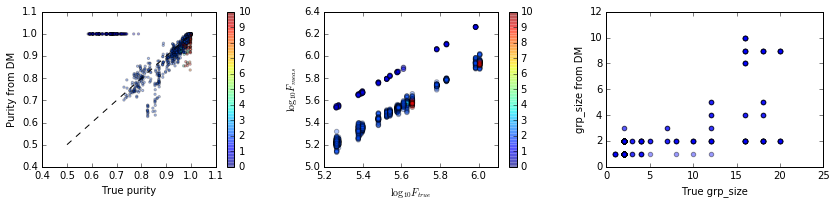

In [61]:
plt.figure(figsize=[14,10])
plt.subplot(3,3,1)
c=['r', 'g', 'b', 'y', 'k', 'm', 'b', 'y', 'k', 'm']
plt.scatter(wl_out['purity'][select_wldeb],
            dm_out['purity'][select_dm],
            c=dm_out["grp_size"][select_dm],
            vmin=0, vmax=10, alpha=0.3, s=5)
plt.plot([0.5,1], [0.5,1], 'k--')
plt.ylabel("Purity from DM")
plt.xlabel("True purity")
plt.colorbar()
plt.subplot(3,3,2)
plt.scatter(np.log10(wl_out['flux'][select_wldeb]),
            np.log10(dm_out['base_SdssShape_flux'][select_dm]),
            c=dm_out["grp_size"][select_dm],
            vmin=0, vmax=10, alpha=0.3)
plt.colorbar()
plt.ylabel("$\log_{10}{F_{meas}}$")
plt.xlabel("$\log_{10}{F_{true}}$ ")
#lims = np.array([np.min(dm_out['base_SdssShape_flux'][select_dm]),
#        np.max(dm_out['base_SdssShape_flux'][select_dm])])
#plt.xlim(lims)
#plt.ylim(lims)


plt.subplot(3,3,3)
plt.scatter(wl_out['grp_size'][select_wldeb],
            dm_out['grp_size'][select_dm],
            alpha=0.4)
#plt.plot([0.5,1], [0.5,1], 'k--')
plt.ylabel("grp_size from DM")
plt.xlabel("True grp_size")



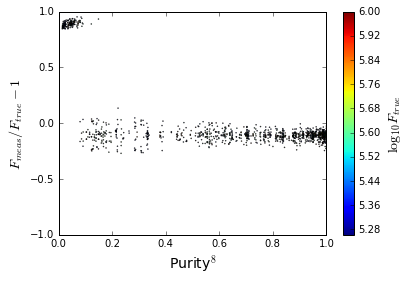

In [62]:
d_flux = ( dm_out['base_SdssShape_flux'][select_dm] - wl_out['flux'][select_wldeb]) / wl_out['flux'][select_wldeb]
plt.scatter(wl_out['purity'][select_wldeb]**8,d_flux,
            c=np.log10(wl_out['flux'][select_wldeb]),
            vmax=6, s=0.2)
plt.ylim(-1,1)
plt.xlim(0,1)
cbar = plt.colorbar()
cbar.set_label(label='$\log_{10}{F_{true}}$',size=14)
plt.xlabel('Purity$^{8}$',fontsize=14)
plt.ylabel('$F_{meas}/F_{true}-1$',fontsize=14);

## Exercise:
Q) Plot relation between purity and snr

Q) Plot histograms of shift in centroid estimated by DM?

Q) DM has other blendedness parameters. How do they compare to purity?

Q) Compare true purity of detected objects and undetected objects